In [241]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (24,8)

In [242]:
# Hyperparameter definieren
learning_rate = 1e-3
batch_size = 64

**Train dataset**

In [243]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [244]:
def standardize(image: torch.Tensor) -> torch.Tensor:
    image /= 255.
    return image

In [245]:
transforms=Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 100.),
    Lambda(standardize)
])

In [246]:
# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms
)

Files already downloaded and verified
Files already downloaded and verified


In [247]:
training_data.data.shape, test_data.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [248]:
training_data.data.min(), training_data.data.max()

(0, 255)

In [249]:
# daten zu float 32 konvertieren
# alles durch 255 dividieren
# training_data.data/255 - > 0 bis 1
# image vor dem AE mit Noise und nach der Eingabe - hoffentlich dann ohne Noise ausgeben

train_noise = torch.tensor(np.random.randn(50000, 32, 32, 3)*100, dtype=torch.float32)

test_noise = torch.tensor(np.random.randn(10000, 32, 32, 3)*100, dtype=torch.float32)

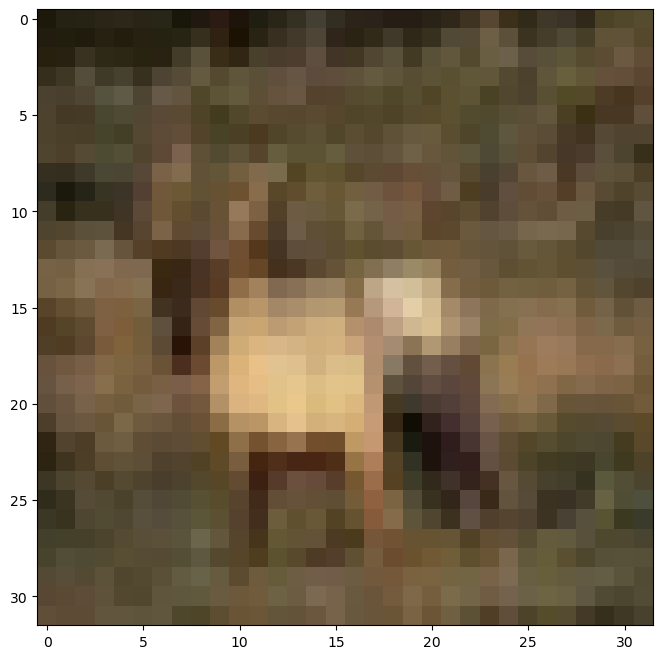

In [250]:
plt.imshow(training_data.data[3])

In [252]:
train = (torch.tensor(training_data.data).type(torch.float32) + train_noise)/255.
test = (torch.tensor(test_data.data).type(torch.float32) + test_noise)/255.

# train = (training_data.data.type(torch.float32) + train_noise)/255.
# test = (test_data.data.type(torch.float32) + test_noise)/255.

In [253]:
train.shape, test.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([10000, 32, 32, 3]))

In [254]:
training_data_ae = TensorDataset(train, train)
test_data_ae = TensorDataset(test, test)

In [255]:
#training_data_ae.transform = transforms
#test_data_ae.transform = transforms

In [256]:


# Create data loaders.
train_dataloader = DataLoader(training_data_ae, batch_size=batch_size)
test_dataloader = DataLoader(test_data_ae, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [Batch Size, Channels, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype) # SAME AS INPUT
    break

Shape of X [Batch Size, Channels, H, W]:  torch.Size([64, 32, 32, 3])
Shape of y:  torch.Size([64, 32, 32, 3]) torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.4829) tensor(2.4980)


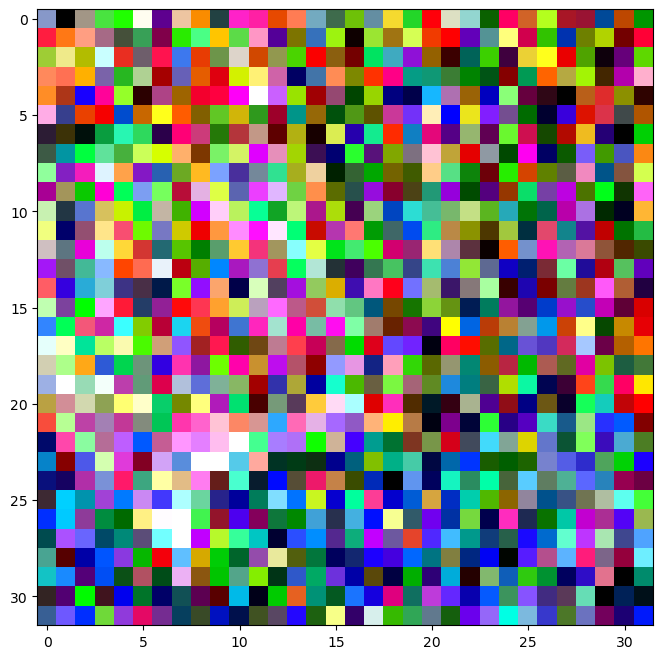

In [257]:
data, labels = next(iter(test_dataloader))
print(torch.min(data), torch.max(data))
img = data.detach().numpy()*255
img = img.astype(int)
plt.imshow(img[0]);

**Examine Dataset Range**

In [258]:
data, labels = next(iter(train_dataloader))
print(torch.min(data), torch.max(data))

tensor(-1.5934) tensor(2.5573)


**Model**

In [259]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 128), nn.ReLU(), # use tanh
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            #nn.Linear(16, 4), nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            #nn.Linear(4, 16), nn.ReLU(),
            nn.Linear(16, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 32*32*3),nn.Sigmoid()  # Data value range [0, 1]
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        out = self.decoder(x)
        out = torch.reshape(out, (-1, 32, 32, 3))
        return out

model = DenoisingAutoencoder()

In [260]:
# Initialize the loss function
loss_fn = nn.MSELoss()

In [261]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [262]:
# Training Loop
# In TF kann man einfach fitten, in PyTorch muss man selbst loopen

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # Von da wissen wir die Anzahl der Zyklen
    for batch, (X, y) in enumerate(dataloader): # X == y
        # Compute prediction and loss
        recon = model(X) # reconstructed data
        loss = loss_fn(recon, X) # benchmark recon against X

        # Backpropagation
        optimizer.zero_grad()

        # Gradienten auf x Berechnen
        # In tensorflow: Apply gradient oder Gewicht = Gewicht + LearningRate*Gradient
        loss.backward()
        # Uberschreiben aller Gewichte und Biases mit neuen Werten
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss, Train: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [263]:
def test_loop(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)
    test_loss = 0.
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()


    test_loss /= size
    print(f"Avg loss, Test: {test_loss:>8f} \n")

    return test_loss

In [264]:
epochs = 10
test_losses = []
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")


loss, Train: 0.217227  [    0/50000]
loss, Train: 0.184014  [32000/50000]
Avg loss, Test: 0.002932 

loss, Train: 0.186433  [    0/50000]
loss, Train: 0.183572  [32000/50000]
Avg loss, Test: 0.002932 

loss, Train: 0.186589  [    0/50000]
loss, Train: 0.181353  [32000/50000]
Avg loss, Test: 0.002892 

loss, Train: 0.183918  [    0/50000]
loss, Train: 0.180539  [32000/50000]
Avg loss, Test: 0.002873 

loss, Train: 0.182665  [    0/50000]
loss, Train: 0.178539  [32000/50000]
Avg loss, Test: 0.002858 

loss, Train: 0.182177  [    0/50000]
loss, Train: 0.178428  [32000/50000]
Avg loss, Test: 0.002855 

loss, Train: 0.182003  [    0/50000]
loss, Train: 0.178416  [32000/50000]
Avg loss, Test: 0.002852 

loss, Train: 0.181773  [    0/50000]
loss, Train: 0.178753  [32000/50000]
Avg loss, Test: 0.002849 

loss, Train: 0.181564  [    0/50000]
loss, Train: 0.178379  [32000/50000]
Avg loss, Test: 0.002848 

loss, Train: 0.181428  [    0/50000]
loss, Train: 0.178413  [32000/50000]
Avg loss, Test: 0

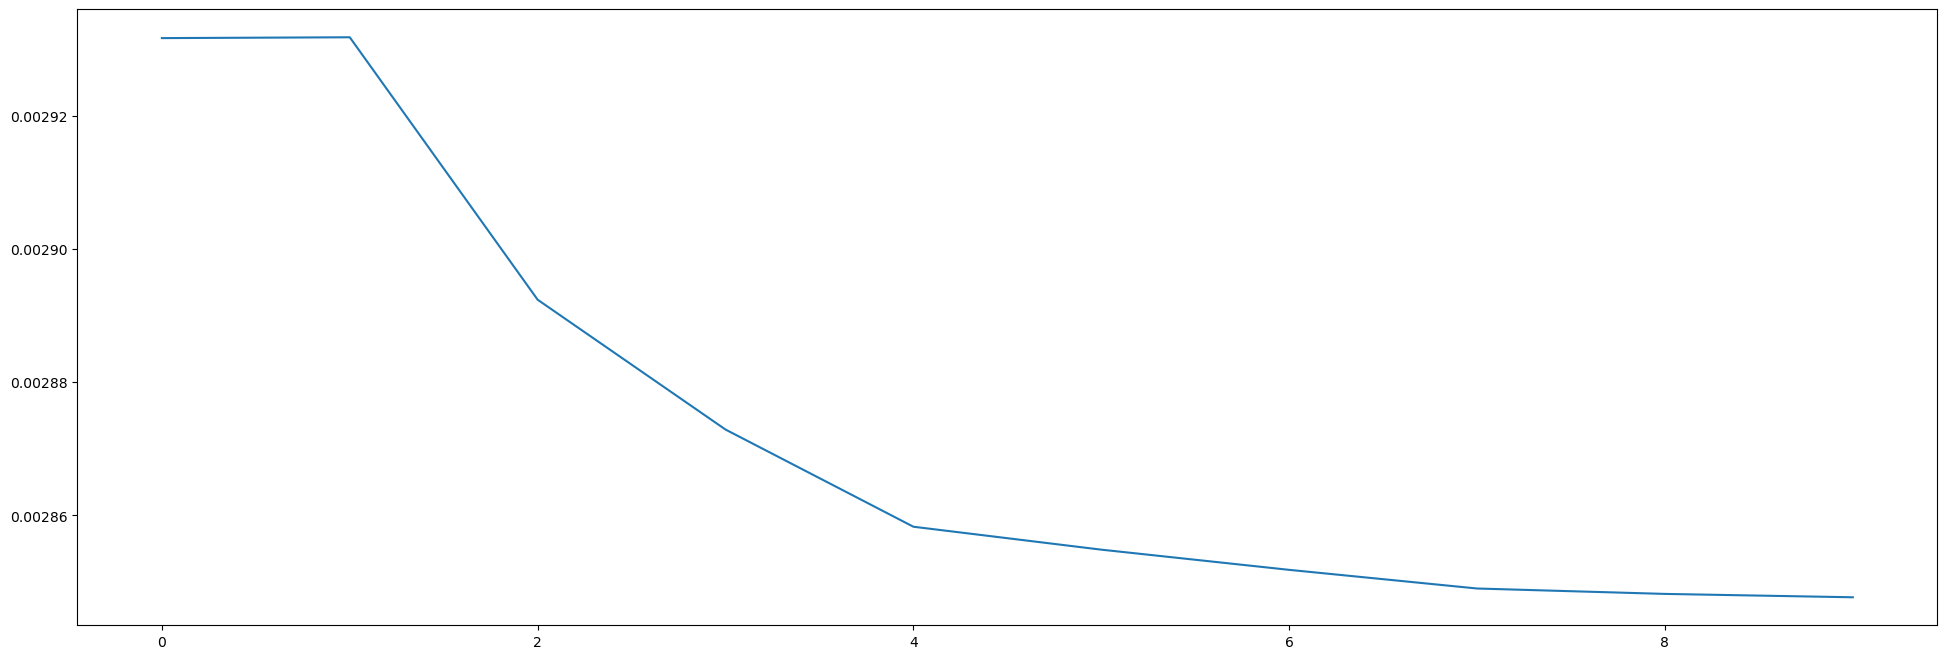

In [265]:
plt.plot(np.array(test_losses));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.4829) tensor(2.4980)


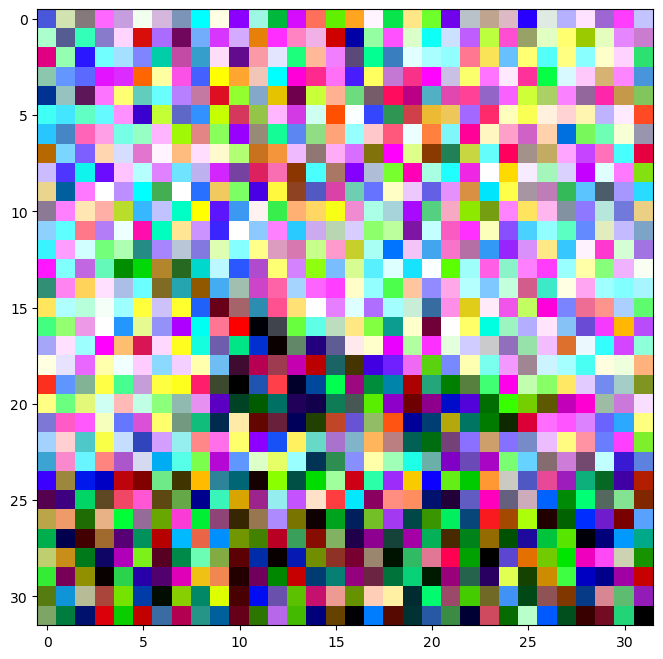

In [266]:
data, labels = next(iter(test_dataloader))
print(torch.min(data), torch.max(data))
img = data.detach().numpy()*255
img = img.astype(int)
plt.imshow(img[3].squeeze(), cmap='gray');

In [267]:
img.shape

(64, 32, 32, 3)

In [268]:
img_new = model(data)


In [269]:
img_new = (img_new.detach().numpy()*255).astype(int)
print(img_new)

[[[[114 114 113]
   [106 117 114]
   [109 114 112]
   ...
   [ 82  86  84]
   [ 87  89  80]
   [ 82  88  83]]

  [[103 117 110]
   [110 116 111]
   [109 116 110]
   ...
   [ 78  87  85]
   [ 81  87  81]
   [ 80  90  78]]

  [[103 112 110]
   [112 117 107]
   [105 113 107]
   ...
   [ 78  81  79]
   [ 79  83  74]
   [ 83  85  77]]

  ...

  [[123 124 118]
   [124 127 117]
   [129 126 117]
   ...
   [ 92  92  79]
   [ 90  91  79]
   [ 90  92  81]]

  [[124 122 113]
   [123 122 117]
   [124 127 114]
   ...
   [ 93  91  83]
   [ 90  93  86]
   [ 92  97  84]]

  [[124 123 112]
   [119 127 110]
   [124 124 112]
   ...
   [ 96  96  78]
   [ 92  93  85]
   [ 91  96  83]]]


 [[[207 219 235]
   [202 214 239]
   [202 221 240]
   ...
   [222 233 246]
   [225 231 243]
   [217 231 243]]

  [[206 219 238]
   [205 224 236]
   [204 221 236]
   ...
   [217 237 248]
   [221 231 246]
   [226 233 244]]

  [[200 217 237]
   [201 216 238]
   [203 218 234]
   ...
   [222 231 247]
   [229 231 245]
   [222 235

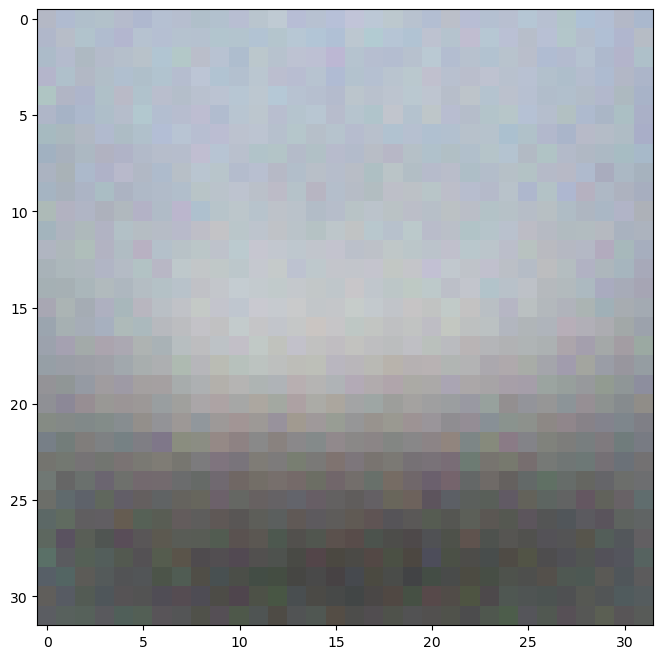

In [270]:
plt.imshow(img_new[3])